<a href="https://colab.research.google.com/github/seifukaleab/BIS_Project_2025/blob/main/BIS_Project_VINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pm4py matplotlib seaborn plotly

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#import libraries
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.filtering.pandas.attributes import attributes_filter
from pm4py.algo.filtering.pandas.end_activities import end_activities_filter
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
import matplotlib.pyplot as plt

In [ ]:
#Load the event log
event_log = xes_importer.apply("/Users/kaleabeseifu/Documents/uniMI/Second Semester/Business Information System/FInal Project /BPI_Challenge_2013_incidents.xes")

# Convert to pm4py event log
df_log = log_converter.apply(event_log, variant=log_converter.Variants.TO_DATA_FRAME)
df_log['time:timestamp']= pd.to_datetime(df_log['time:timestamp'])

df_log

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 7554/7554 [00:01<00:00, 4903.74it/s]


,org:group,resource country,organization country,org:resource,organization involved,org:role,concept:name,impact,product,lifecycle:transition,time:timestamp,case:concept:name
0,V30,France,fr,Frederic,Org line A2,A2_4,Accepted,Medium,PROD582,In Progress,2010-03-31 16:59:42+00:00,1-364285768
1,V30,France,fr,Frederic,Org line A2,A2_4,Accepted,Medium,PROD582,In Progress,2010-03-31 17:00:56+00:00,1-364285768
2,V5 3rd,France,fr,Frederic,Org line A2,A2_5,Queued,Medium,PROD582,Awaiting Assignment,2010-03-31 17:45:48+00:00,1-364285768
3,V5 3rd,France,fr,Anne Claire,Org line A2,A2_5,Accepted,Medium,PROD582,In Progress,2010-04-06 16:44:07+00:00,1-364285768
4,V30,France,fr,Anne Claire,Org line A2,A2_4,Queued,Medium,PROD582,Awaiting Assignment,2010-04-06 16:44:38+00:00,1-364285768
...,...,...,...,...,...,...,...,...,...,...,...,...
65528,C9,Brazil,br,Lierson,Org line C,V3_2,Completed,Low,PROD424,In Call,2012-05-05 04:07:43+00:00,1-740866691
65529,C9,Brazil,br,Lierson,Org line C,V3_2,Accepted,Medium,PROD562,In Progress,2012-05-05 06:58:40+00:00,1-740866708
65530,C9,Brazil,br,Lierson,Org line C,V3_2,Accepted,Medium,PROD562,In Progress,2012-05-05 07:02:39+00:00,1-740866708
65531,C9,Brazil,br,Lierson,Org line C,V3_2,Completed,Medium,PROD562,In Call,2012-05-05 07:23:03+00:00,1-740866708


In [ ]:
#Merge lifecycle:transition and concept:name to get all activities
df_log['concept:name'] = (
    df_log['concept:name'].astype(str) + "/" +
    df_log['lifecycle:transition'].astype(str)

)
activities = df_log['concept:name'].value_counts()
print("\nActivity types in the Incident Handling logp':")
print(activities)
#relevant_coluns to keep
relevant_columns = [
    'case:concept:name', 'concept:name', 'time:timestamp',
    'org:group', 'org:role', 'organization involved'
]
df_log = df_log[relevant_columns]


Activity types in the Incident Handling logp':
concept:name
Accepted/In Progress              30239
Queued/Awaiting Assignment        11544
Completed/Resolved                 6115
Completed/Closed                   5716
Accepted/Wait - User               4217
Accepted/Assigned                  3221
Completed/In Call                  2035
Accepted/Wait                      1533
Accepted/Wait - Implementation      493
Accepted/Wait - Vendor              313
Accepted/Wait - Customer            101
Unmatched/Unmatched                   5
Completed/Cancelled                   1
Name: count, dtype: int64


In [ ]:
# Split support team into support team and support line number from org:group
# Extract support line number (e.g., "1st", "2nd", "3rd", "2nd-3rd")
df_log = df_log.copy()
df_log['support:level'] = df_log['org:group'].str.extract(r'(1st|2nd|3rd|2nd-3rd)')
# Clean support team by removing support line number
df_log['support:team'] = df_log['org:group'].str.replace(r'(1st|2nd|3rd|2nd-3rd)', '', regex=True).str.strip()

# Assign '1st' to missing support line number
df_log['support:level'] = df_log['support:level'].fillna('1st')

# Validate support line number
valid_support_lines = ['1st', '2nd', '3rd', '2nd-3rd']
invalid_support_lines = df_log[~df_log['support:level'].isin(valid_support_lines)]['support:level'].unique()
if len(invalid_support_lines) > 0:
    print(f"Warning: Invalid support line number values found: {invalid_support_lines}. Replacing with '1st'.")
    df_log.loc[~df_log['support:level'].isin(valid_support_lines), 'support:level'] = '1st'

# Exclude events missing Org line
if df_log['organization involved'].isna().any():
    print(f"Warning: {df_log['organization involved'].isna().sum()} events missing Org line. Dropping affected rows.")
    df_log = df_log.dropna(subset=['organization involved'])

In [ ]:
# Remove cases with <=2 events
case_counts = df_log['case:concept:name'].value_counts()
filtered_log = df_log[df_log['case:concept:name'].isin(case_counts[case_counts > 2].index)]


In [ ]:
#checking number of events and cases
num_events = len(filtered_log)
num_unique_events = len(filtered_log["concept:name"].unique())
num_cases = len(filtered_log["case:concept:name"].unique())
print (num_unique_events)
print ("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases)) #checking cases and events are the same number as stated in the assignment

13
Number of events: 65512
Number of cases: 7543


In [ ]:
# Calculate the duration of each case
case_durations = filtered_log.groupby('case:concept:name').agg(Duration=('time:timestamp', lambda x: (x.max() - x.min()).days))
filter = case_durations[case_durations['Duration'] > 0]
filtered_log = filtered_log[filtered_log['case:concept:name'].isin(filter.index)]
# Print the number of unique active cases with a duration greater than zero
print('Number of active cases: {}'.format(len(filtered_log['case:concept:name'].unique().tolist())))

Number of active cases: 5337


In [ ]:
#getting all the case durations to filter the null durations cases
case_durations = pm4py.get_all_case_durations(filtered_log)
min_cd = min(case_durations)
max_cd = max(case_durations)
mean_cd = np.mean(case_durations)

print("Min Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(min_cd, max_cd, mean_cd)) #there are no cases with time = 0

Min Case Duration: 86417.0
Max Case Duration: 66644793.0
Mean Case Duration: 1472449.0927487353


In [ ]:
# Compute case durations in hours
filtered_log = filtered_log.copy()
filtered_log['time:timestamp'] = pd.to_datetime(filtered_log['time:timestamp'])

case_durations = filtered_log.groupby('case:concept:name')['time:timestamp'].apply(
    lambda x: (x.max() - x.min()).total_seconds() / 3600
)

# Compute mean and standard deviation
mean_duration = case_durations.mean()
std_duration = case_durations.std()
threshold = mean_duration + 3 * std_duration  # 3σ rule

print(f"Mean Duration: {mean_duration:.2f} hours")
print(f"Standard Deviation: {std_duration:.2f} hours")
print(f"Outlier Threshold (Mean + 3σ): {threshold:.2f} hours")

# Filter out cases above threshold
valid_cases = case_durations[case_durations <= threshold].index
filtered_df = filtered_log[filtered_log['case:concept:name'].isin(valid_cases)]

print(f"Original Cases: {filtered_log['case:concept:name'].nunique()}")
print(f"Filtered Cases (no outliers): {filtered_df['case:concept:name'].nunique()}")


Mean Duration: 409.01 hours
Standard Deviation: 785.79 hours
Outlier Threshold (Mean + 3σ): 2766.37 hours
Original Cases: 5337
Filtered Cases (no outliers): 5255


In [ ]:
activity_counts = filtered_df['concept:name'].value_counts().reset_index()
activity_counts.columns = ['Activity', 'Count']
activity_counts['Percentage'] = (activity_counts['Count'] / activity_counts['Count'].sum()) * 100

# Show  activities
print(activity_counts)

                          Activity  Count  Percentage
0             Accepted/In Progress  24505   44.111823
1       Queued/Awaiting Assignment  10694   19.250432
2               Completed/Resolved   5612   10.102247
3                 Completed/Closed   5243    9.438004
4             Accepted/Wait - User   3986    7.175259
5                Accepted/Assigned   3057    5.502952
6                    Accepted/Wait   1406    2.530962
7   Accepted/Wait - Implementation    452    0.813652
8           Accepted/Wait - Vendor    299    0.538234
9                Completed/In Call    195    0.351022
10        Accepted/Wait - Customer     98    0.176411
11             Unmatched/Unmatched      5    0.009001


In [ ]:
# Calculate activity frequencies
activity_counts = filtered_df['concept:name'].value_counts(normalize=True) * 100
# Identify frequent activities (>=1% of total events)
frequent_activities = activity_counts[activity_counts >= 1].index.tolist()

# KEEP Completed/In Call for its one of the end activites
keep_rare_activitie = [
    'Completed/In Call',
]
# Combine frequent activities and rare ones to keep
final_activities = set(frequent_activities).union(set(keep_rare_activitie))

# Filter the log
df_log_cleaned = filtered_df[filtered_df['concept:name'].isin(final_activities)]

# Summary of cleaned log
print("Original activities:", filtered_df['concept:name'].nunique())
print("Cleaned activities:", df_log_cleaned['concept:name'].nunique())
print("Remaining events:", len(df_log_cleaned))
print("\nActivity counts in cleaned log:")
print(df_log_cleaned['concept:name'].value_counts())


Original activities: 12
Cleaned activities: 8
Remaining events: 54698

Activity counts in cleaned log:
concept:name
Accepted/In Progress          24505
Queued/Awaiting Assignment    10694
Completed/Resolved             5612
Completed/Closed               5243
Accepted/Wait - User           3986
Accepted/Assigned              3057
Accepted/Wait                  1406
Completed/In Call               195
Name: count, dtype: int64


In [ ]:
# Allowed start activities
allowed_start_activities = [
    "Accepted/In Progress",
    "Queued/Awaiting Assignment"
]
# Allowed end activities
allowed_end_activities = [
    "Completed/Closed",
    "Completed/Resolved",
    "Completed/In Call"
]
# First filter start activities
case_start_activities = (
    df_log_cleaned.sort_values("time:timestamp")
    .groupby("case:concept:name")
    .head(1)
)[['case:concept:name', 'concept:name']]
valid_start_cases = case_start_activities[
    case_start_activities['concept:name'].isin(allowed_start_activities)
]['case:concept:name']

# Then filter end activities
case_end_activities = (
    df_log_cleaned.sort_values("time:timestamp")
    .groupby("case:concept:name")
    .tail(1)
)[['case:concept:name', 'concept:name']]
valid_end_cases = case_end_activities[
    case_end_activities['concept:name'].isin(allowed_end_activities)
]['case:concept:name']

# Convert Series of case IDs to sets
valid_start_set = set(valid_start_cases)
valid_end_set = set(valid_end_cases)

# Find intersection (common cases)
valid_cases = valid_start_set.intersection(valid_end_set)

# Keep only cases valid in both filters
filtered_log = df_log_cleaned[df_log_cleaned['case:concept:name'].isin(valid_cases)].copy()

print(f"Remaining Cases After Start+End Activity Filter: {filtered_log['case:concept:name'].nunique()}")


Remaining Cases After Start+End Activity Filter: 5232


In [ ]:
#checking which are the start activities and end activities
start_activities = pm4py.get_start_activities(filtered_log)
end_activities = pm4py.get_end_activities(filtered_log)
print ("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'Accepted/In Progress': 4127, 'Queued/Awaiting Assignment': 1105}
End activities: {'Completed/Closed': 5092, 'Completed/In Call': 69, 'Completed/Resolved': 71}


In [ ]:
filtered_log

,case:concept:name,concept:name,time:timestamp,org:group,org:role,organization involved,support:level,support:team
1599,1-642781041,Accepted/In Progress,2012-01-16 14:47:43+00:00,V39 2nd,NaN,Org line B,2nd,V39
1600,1-642781041,Accepted/In Progress,2012-01-16 14:48:34+00:00,V39 2nd,NaN,Org line B,2nd,V39
1601,1-642781041,Completed/Resolved,2012-05-08 17:34:17+00:00,V39 2nd,NaN,Org line B,2nd,V39
1602,1-642781041,Completed/Closed,2012-05-09 01:15:54+00:00,V39 2nd,NaN,Org line B,2nd,V39
1603,1-643338463,Accepted/In Progress,2012-01-17 09:59:56+00:00,D7,A2_1,Org line A2,1st,D7
...,...,...,...,...,...,...,...,...
65521,1-740865969,Queued/Awaiting Assignment,2012-05-04 22:53:37+00:00,D3,A2_1,Org line B,1st,D3
65522,1-740865969,Accepted/In Progress,2012-05-07 15:05:13+00:00,D3,A2_1,Org line B,1st,D3
65523,1-740865969,Accepted/Wait,2012-05-07 15:23:50+00:00,D3,A2_1,Org line B,1st,D3
65524,1-740865969,Completed/Resolved,2012-05-07 21:06:53+00:00,D3,A2_1,Org line B,1st,D3


In [ ]:
filtered_log= filtered_log.copy()
filtered_log['time:timestamp'] = pd.to_datetime(filtered_log['time:timestamp'])
filtered_log = filtered_log.sort_values(by=['case:concept:name', 'time:timestamp'])

# Group events into variants
filtered_log['activity'] = filtered_log['concept:name']
variant_df = filtered_log.groupby('case:concept:name')['activity'].apply(list).reset_index()
variant_df['variant'] = variant_df['activity'].apply(lambda x: ' → '.join(x))
# Count variant frequency
variant_counts = variant_df['variant'].value_counts()


# Choose top N variants
top_n_variants = variant_counts.head(30).index.tolist()

print("Top 30 Variants:", top_n_variants)

Top 30 Variants: ['Accepted/In Progress → Accepted/In Progress → Completed/Resolved → Completed/Closed', 'Accepted/In Progress → Accepted/In Progress → Queued/Awaiting Assignment → Accepted/In Progress → Completed/Resolved → Completed/Closed', 'Queued/Awaiting Assignment → Accepted/In Progress → Completed/Resolved → Completed/Closed', 'Accepted/In Progress → Accepted/In Progress → Queued/Awaiting Assignment → Accepted/In Progress → Accepted/Wait - User → Completed/Resolved → Completed/Closed', 'Accepted/In Progress → Accepted/In Progress → Queued/Awaiting Assignment → Accepted/In Progress → Queued/Awaiting Assignment → Accepted/In Progress → Completed/Resolved → Completed/Closed', 'Accepted/In Progress → Accepted/In Progress → Accepted/Wait - User → Completed/Resolved → Completed/Closed', 'Queued/Awaiting Assignment → Accepted/In Progress → Queued/Awaiting Assignment → Accepted/In Progress → Completed/Resolved → Completed/Closed', 'Accepted/In Progress → Accepted/In Progress → Queued/A

In [ ]:
# Keep only cases that belong to top variants
top_cases = variant_df[variant_df['variant'].isin(top_n_variants)]['case:concept:name']
filtered_df = filtered_log[filtered_log['case:concept:name'].isin(top_cases)]

print(f"length of original DataFrame : {len(filtered_log)}")
print(f"Length of filtered for frequent path :{len(filtered_df)}")
print("Length of filtered :", len(filtered_df["case:concept:name"].unique()))

length of original DataFrame : 54536
Length of filtered for frequent path :14735
Length of filtered : 2493


In [ ]:
#getting all the case durations to filter the null durations cases
case_durations = pm4py.get_all_case_durations(filtered_df)
min_cd = min(case_durations)
max_cd = max(case_durations)
mean_cd = np.mean(case_durations)

print("Min Case Duration: {}\nMax Case Duration: {}\nMean Case Duration: {}".format(min_cd, max_cd, mean_cd)) #there are no cases with time = 0

Min Case Duration: 87854.0
Max Case Duration: 9800891.0
Mean Case Duration: 908313.432009627


In [ ]:
support_line_logs = {}
for lines in filtered_df['support:level'].unique():
    lines_log = filtered_df[filtered_df['support:level'] == lines]
    support_line_logs[lines] = lines_log
    print(f"Support Line {lines}: {lines_log['case:concept:name'].nunique()} cases")


Support Line 2nd: 1031 cases
Support Line 3rd: 177 cases
Support Line 1st: 1965 cases


In [ ]:
# 1️ Count number of cases handled per support line
lines_case_counts = {
    lines: lines_log['case:concept:name'].nunique()
    for lines, lines_log in support_line_logs.items()
}

# 2 Get top 3 support lines by number of cases
Support_lines = sorted(lines_case_counts.items(), key=lambda x: x[1], reverse=True)[:3]
print("Support Lines (by cases handled):")
for lines, count in Support_lines:
    print(f"{lines}: {count} cases")

# 3️ Perform statistics for each support line
for lines, _ in Support_lines:
    # Get actual log from support_line_logs, not from counts
    lines_log = support_line_logs[lines].copy()  # Make copy to avoid SettingWithCopyWarning

    # Ensure timestamp column is datetime
    lines_log['time:timestamp'] = pd.to_datetime(lines_log['time:timestamp'])

    # Compute case durations
    case_durations = lines_log.groupby('case:concept:name')['time:timestamp'].apply(
        lambda x: (x.max() - x.min()).total_seconds() / 3600  # Duration in hours
    )

    print(f"\n Statistics for Support Line: {lines}")
    print(f"Total Cases: {lines_log['case:concept:name'].nunique()}")
    print(f"Total Events: {len(lines_log)}")
    print(f"Min Duration: {case_durations.min():.2f} hours")
    print(f"Max Duration: {case_durations.max():.2f} hours")
    print(f"Mean Duration: {case_durations.mean():.2f} hours")
    print(f"Median Duration: {case_durations.median():.2f} hours")


Support Lines (by cases handled):
1st: 1965 cases
2nd: 1031 cases
3rd: 177 cases

 Statistics for Support Line: 1st
Total Cases: 1965
Total Events: 9353
Min Duration: 0.00 hours
Max Duration: 2505.83 hours
Mean Duration: 169.85 hours
Median Duration: 178.22 hours

 Statistics for Support Line: 2nd
Total Cases: 1031
Total Events: 4557
Min Duration: 0.00 hours
Max Duration: 2722.47 hours
Mean Duration: 249.85 hours
Median Duration: 184.06 hours

 Statistics for Support Line: 3rd
Total Cases: 177
Total Events: 825
Min Duration: 0.00 hours
Max Duration: 2702.62 hours
Mean Duration: 255.42 hours
Median Duration: 183.73 hours


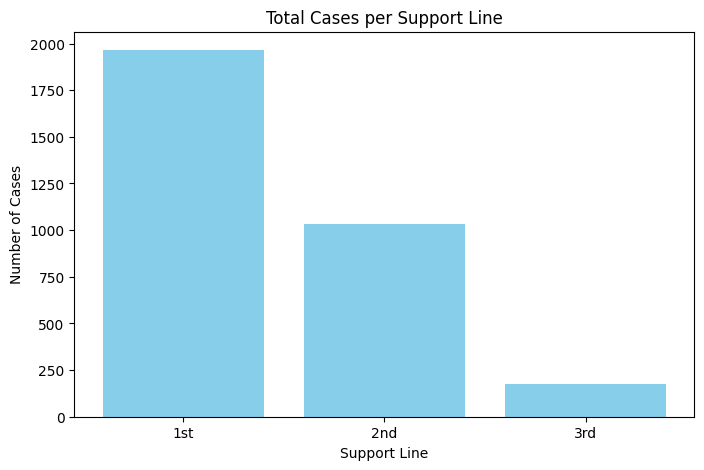

/var/folders/6t/zkl3g6z12wd63lbx0qkq91s00000gn/T/ipykernel_72450/4270938261.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(stats_df['Durations'], labels=stats_df['Support Line'])


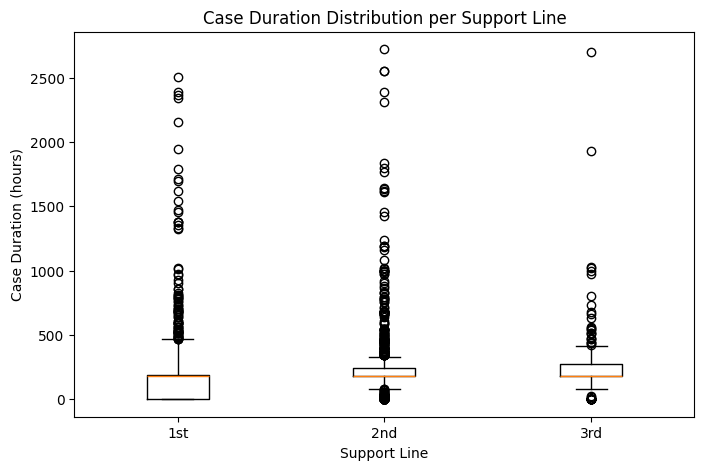

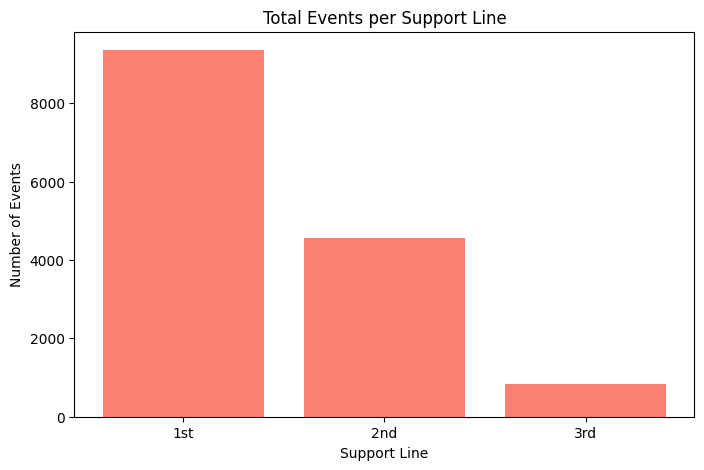

In [ ]:
import matplotlib.pyplot as plt

# Store statistics for plotting
stats_summary = []

for lines, _ in Support_lines:
    lines_log = support_line_logs[lines].copy()
    lines_log['time:timestamp'] = pd.to_datetime(lines_log['time:timestamp'])

    # Compute case durations
    case_durations = lines_log.groupby('case:concept:name')['time:timestamp'].apply(
        lambda x: (x.max() - x.min()).total_seconds() / 3600  # Duration in hours
    )

    stats_summary.append({
        'Support Line': lines,
        'Total Cases': lines_log['case:concept:name'].nunique(),
        'Total Events': len(lines_log),
        'Mean Duration (h)': case_durations.mean(),
        'Median Duration (h)': case_durations.median(),
        'Durations': case_durations.tolist()
    })

# Convert summary to DataFrame
import pandas as pd
stats_df = pd.DataFrame(stats_summary)

# 1. Bar Chart of Total Cases
plt.figure(figsize=(8, 5))
plt.bar(stats_df['Support Line'], stats_df['Total Cases'], color='skyblue')
plt.title('Total Cases per Support Line')
plt.xlabel('Support Line')
plt.ylabel('Number of Cases')
plt.show()

# 2. Boxplot of Case Durations
plt.figure(figsize=(8, 5))
plt.boxplot(stats_df['Durations'], labels=stats_df['Support Line'])
plt.title('Case Duration Distribution per Support Line')
plt.xlabel('Support Line')
plt.ylabel('Case Duration (hours)')
plt.show()

# 3. Bar Chart of Total Events
plt.figure(figsize=(8, 5))
plt.bar(stats_df['Support Line'], stats_df['Total Events'], color='salmon')
plt.title('Total Events per Support Line')
plt.xlabel('Support Line')
plt.ylabel('Number of Events')
plt.show()


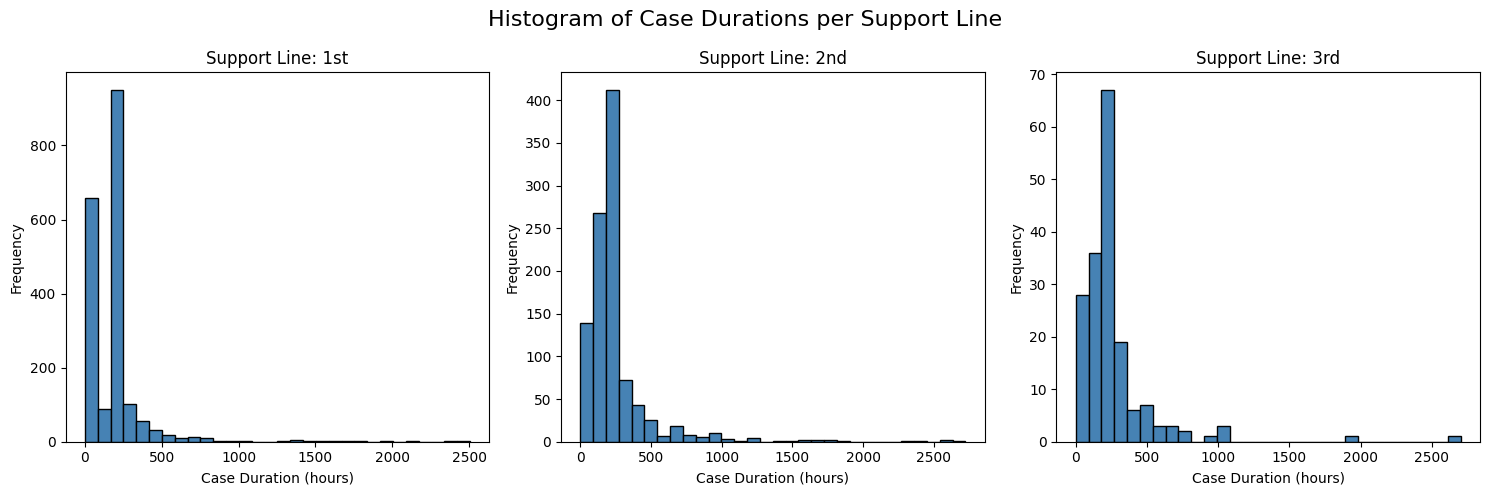

In [ ]:
import matplotlib.pyplot as plt

# Create histograms for case durations per support line
plt.figure(figsize=(15, 5))

# Loop through top support lines
for idx, (lines, _) in enumerate(Support_lines, start=1):
    lines_log = support_line_logs[lines].copy()
    lines_log['time:timestamp'] = pd.to_datetime(lines_log['time:timestamp'])

    # Compute case durations
    case_durations = lines_log.groupby('case:concept:name')['time:timestamp'].apply(
        lambda x: (x.max() - x.min()).total_seconds() / 3600  # Duration in hours
    )

    # Plot histogram
    plt.subplot(1, len(Support_lines), idx)
    plt.hist(case_durations, bins=30, color='steelblue', edgecolor='black')
    plt.title(f"Support Line: {lines}")
    plt.xlabel('Case Duration (hours)')
    plt.ylabel('Frequency')

plt.suptitle('Histogram of Case Durations per Support Line', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Count cases per organization
org_case_counts = filtered_df.groupby('organization involved')['case:concept:name'].nunique()
# Get top 3 organizations by case count
top_3_orgs = org_case_counts.sort_values(ascending=False).head(3).index.tolist()
# Segment logs for top 3 organizations
org_line_logs = {}
for org in top_3_orgs:
    org_log = filtered_df[filtered_df['organization involved'] == org]
    org_line_logs[org] = org_log
    print(f"Organization {org}: {org_log['case:concept:name'].nunique()} cases")


Organization Org line C: 1865 cases
Organization Org line A2: 675 cases
Organization Org line G4: 149 cases


In [ ]:
# Cell 11: Create separate DataFrames for top 3 org:group units
df_C = filtered_df[filtered_df['organization involved'] == top_3_orgs[0]] if len(top_3_orgs) > 0 else pd.DataFrame()
df_A2 = filtered_df[filtered_df['organization involved'] == top_3_orgs[1]] if len(top_3_orgs) > 1 else pd.DataFrame()
df_G4 = filtered_df[filtered_df['organization involved'] == top_3_orgs[2]] if len(top_3_orgs) > 2 else pd.DataFrame()

# Convert to pm4py logs for conformance checking
log_C = log_converter.apply(df_C, variant=log_converter.Variants.TO_EVENT_LOG) if not df_C.empty else None
log_A2 = log_converter.apply(df_A2, variant=log_converter.Variants.TO_EVENT_LOG) if not df_A2.empty else None
log_G4 = log_converter.apply(df_G4, variant=log_converter.Variants.TO_EVENT_LOG) if not df_G4.empty else None

# Store DataFrames and logs
org_dfs = {top_3_orgs[0]: df_C, top_3_orgs[1]: df_A2, top_3_orgs[2]: df_G4}
org_logs = {top_3_orgs[0]: log_C, top_3_orgs[1]: log_A2, top_3_orgs[2]: log_G4}

print(f"Events in C: {len(df_C)}, A2: {len(df_A2)}, G4: {len(df_G4)}")
print(f"Traces in C: {len(df_C['case:concept:name'].unique())}, "
      f"A2: {len(df_A2['case:concept:name'].unique())}, "
      f"G4: {len(df_G4['case:concept:name'].unique())}")

Events in C: 9338, A2: 3120, G4: 564
Traces in C: 1865, A2: 675, G4: 149


In [ ]:
def detect_ping_pong(df):
    ping_pong_transitions = []
    # Define activities to consider for ping-pong behavior
    ping_pong_activities = [
        'Accepted/In Progress', 'Accepted/Assigned', 'Queued/Awaiting Assignment'
    ]

    # Sort log by case and timestamp
    df_sorted = df.sort_values(['case:concept:name', 'time:timestamp'])

    # Group by case
    for case_id, group in df_sorted.groupby('case:concept:name'):
        group = group.reset_index(drop=True)
        activities = group['concept:name'].str.split('_').str[0]  # Remove lifecycle suffix
        org_groups = group['org:group']
        timestamps = group['time:timestamp']

        for i in range(len(group) - 2):
            current_activity = activities[i]
            next_activity = activities[i+1]
            return_activity = activities[i+2]

            # Check ping-pong pattern
            if (current_activity in ping_pong_activities and
                next_activity in ping_pong_activities and
                return_activity in ping_pong_activities and
                org_groups.iloc[i] != org_groups.iloc[i+1] and
                org_groups.iloc[i] == org_groups.iloc[i+2]):

                group_pair = (org_groups.iloc[i], org_groups.iloc[i+1])
                duration = (timestamps.iloc[i+2] - timestamps.iloc[i]).total_seconds() / 3600

                ping_pong_transitions.append({
                    'case_id': case_id,
                    'group_pair': group_pair,
                    'activity_sequence': f"{current_activity} -> {next_activity} -> {return_activity}",
                    'duration': duration,
                    'start_time': timestamps.iloc[i]
                })

    return pd.DataFrame(ping_pong_transitions)

# Apply to your filtered DataFrame
ping_pong_df = detect_ping_pong(filtered_df)

# Preview results
print(ping_pong_df.head())


       case_id            group_pair  \
0  1-715677131  (G121 2nd, G120 3rd)   
1  1-733078101   (V55 3rd, G345 2nd)   
2  1-734732031         (T17 2nd, D1)   
3  1-734732031         (D1, T17 2nd)   
4  1-734792611   (G358 2nd, G66 2nd)   

                                   activity_sequence    duration  \
0  Accepted/In Progress -> Queued/Awaiting Assign...  677.238056   
1  Accepted/In Progress -> Queued/Awaiting Assign...    1.197500   
2  Accepted/In Progress -> Queued/Awaiting Assign...  121.952222   
3  Queued/Awaiting Assignment -> Accepted/In Prog...   47.271389   
4  Accepted/In Progress -> Queued/Awaiting Assign...    0.115278   

                 start_time  
0 2012-04-16 11:16:42+00:00  
1 2012-04-26 11:44:11+00:00  
2 2012-04-27 09:45:58+00:00  
3 2012-04-30 12:37:50+00:00  
4 2012-04-27 11:40:04+00:00  


In [ ]:
# Count occurrences of each activity sequence
activity_sequences = ping_pong_df['activity_sequence'].value_counts().reset_index()
activity_sequences.columns = ['activity_sequence', 'count']
# Calculate average duration for each activity sequence
duration = ping_pong_df.groupby('activity_sequence')['duration'].mean().reset_index()
duration.columns = ['activity_sequence', 'average_duration']
# Merge counts and durations
sequence_summary = activity_sequences.merge(duration, on='activity_sequence')
# Print as a clean table
print(sequence_summary.to_string(index=False))


                                                               activity_sequence  count  average_duration
      Accepted/In Progress -> Queued/Awaiting Assignment -> Accepted/In Progress     24         43.471863
Queued/Awaiting Assignment -> Accepted/In Progress -> Queued/Awaiting Assignment      4         11.855000
Accepted/In Progress -> Queued/Awaiting Assignment -> Queued/Awaiting Assignment      1         92.241944


Most common ping-pong org:group pairs:
group_pair
(N36, N51)              5
(G209 2nd, G324)        2
(G121 2nd, G120 3rd)    1
(G271 2nd, G40)         1
(G331 3rd, M23 2nd)     1
Name: count, dtype: int64

Ping-pong frequency: 29
Average ping-pong duration (hours): 40.792643678160914

Most involved org:group units in ping-pong behavior:
group_pair
N51         5
N36         5
G96         3
G209 2nd    3
G324        3
Name: count, dtype: int64


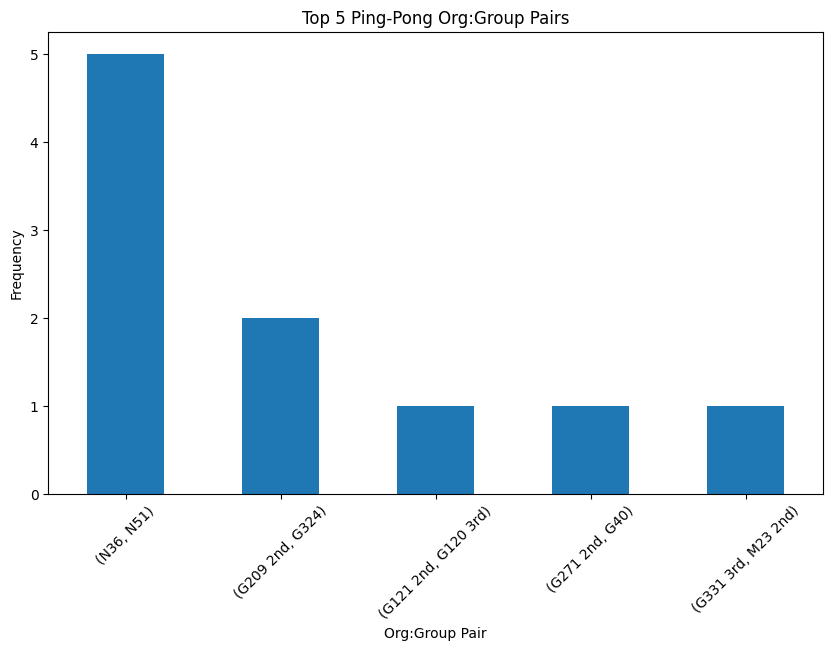

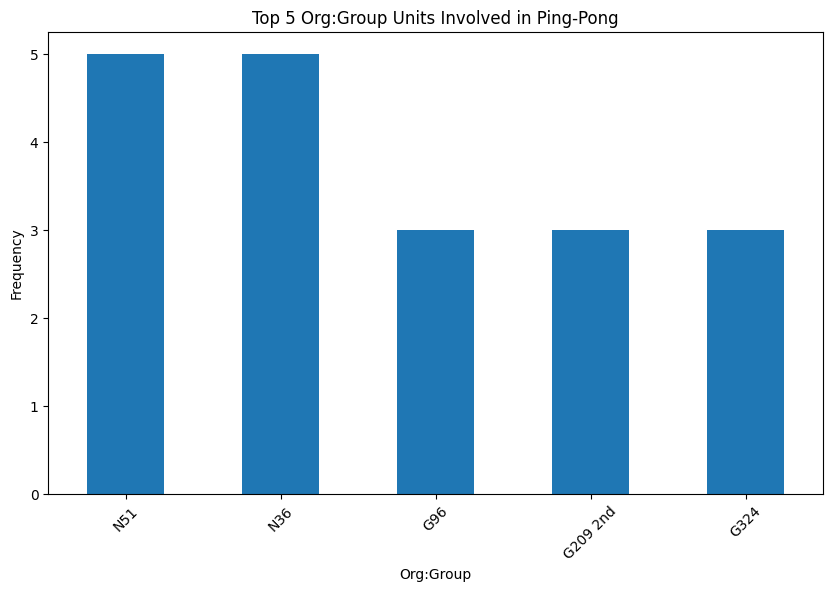

In [ ]:
import plotly.graph_objects as go
if not ping_pong_df.empty:
    group_pair_counts = ping_pong_df['group_pair'].value_counts()
    print("Most common ping-pong org:group pairs:")
    print(group_pair_counts.head())
    print("\nPing-pong frequency:", len(ping_pong_df))
    print("Average ping-pong duration (hours):", ping_pong_df['duration'].mean())

    # Identify most involved org:group units
    involved_groups = pd.concat([ping_pong_df['group_pair'].apply(lambda x: x[0]),
                                ping_pong_df['group_pair'].apply(lambda x: x[1])]).value_counts()
    print("\nMost involved org:group units in ping-pong behavior:")
    print(involved_groups.head())

    # Plot ping-pong frequency by org:group pair
    plt.figure(figsize=(10, 6))
    group_pair_counts[:5].plot(kind='bar')
    plt.title('Top 5 Ping-Pong Org:Group Pairs')
    plt.xlabel('Org:Group Pair')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

    # Plot most involved org:group units
    plt.figure(figsize=(10, 6))
    involved_groups[:5].plot(kind='bar')
    plt.title('Top 5 Org:Group Units Involved in Ping-Pong')
    plt.xlabel('Org:Group')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

else:
    print("No ping-pong behavior detected between org:group units.")

In [ ]:
# Ensure timestamp column is in datetime format
df_A2= df_A2.copy()
df_C = df_C.copy()
df_A2['time:timestamp'] = pd.to_datetime(df_A2['time:timestamp'])
df_C['time:timestamp'] = pd.to_datetime(df_C['time:timestamp'])

# Convert to event logs
df_a2 = dataframe_utils.convert_timestamp_columns_in_df(df_A2)
df_c = dataframe_utils.convert_timestamp_columns_in_df(df_C)

log_a2 = log_converter.apply(df_a2)
log_c = log_converter.apply(df_c)

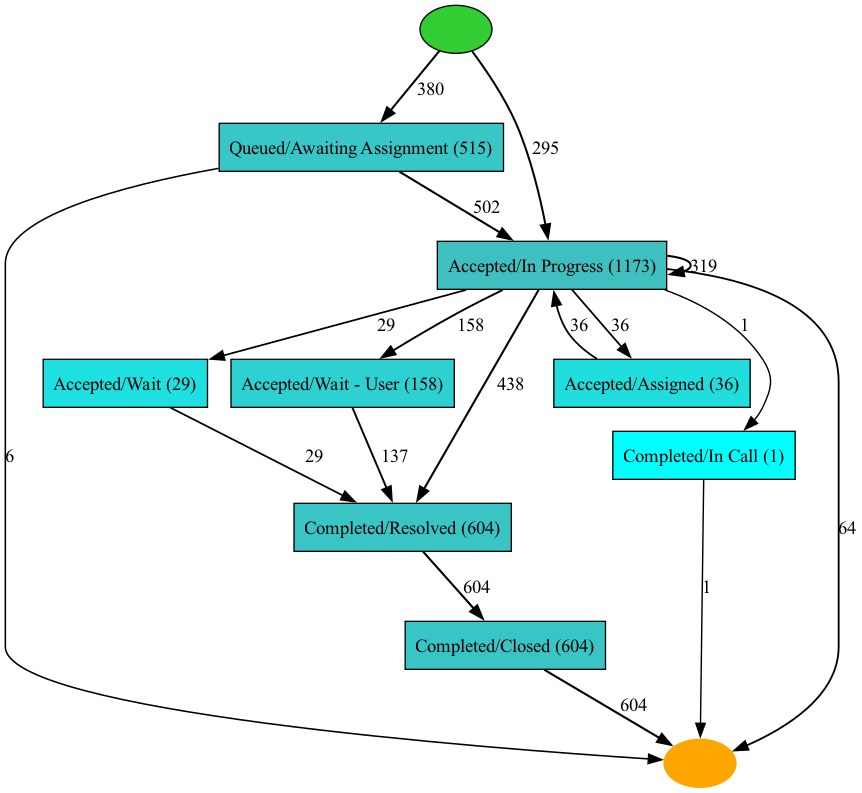

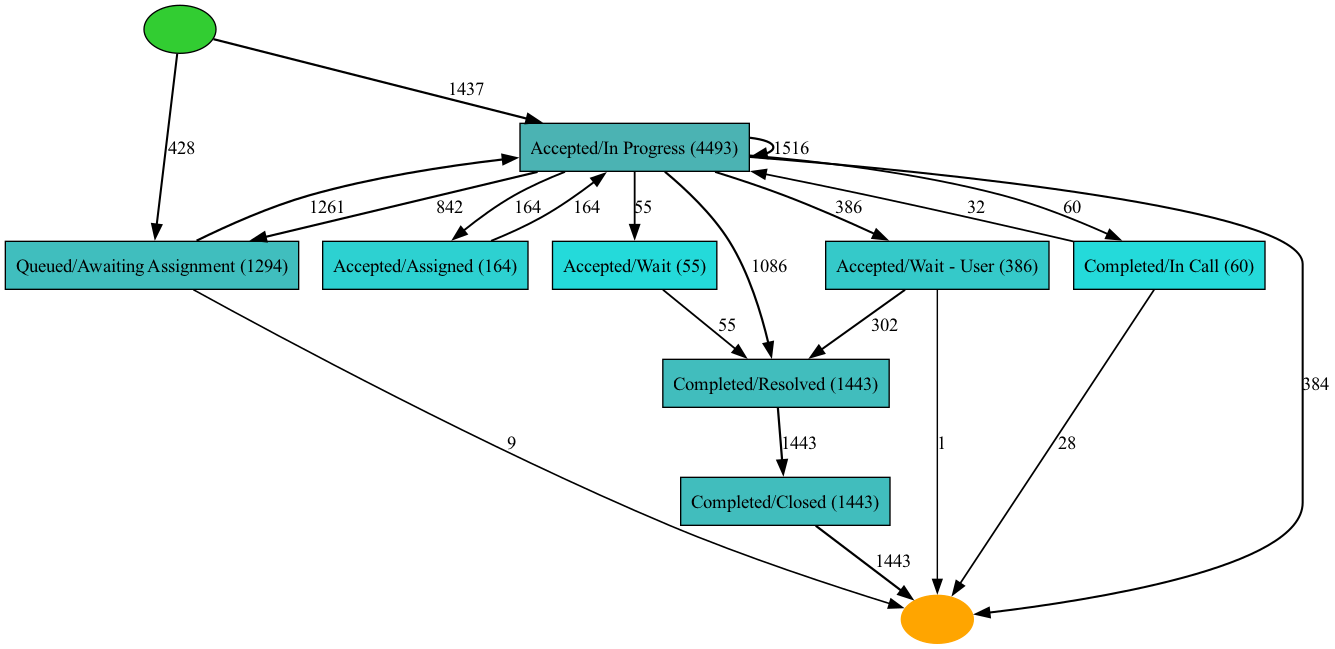

In [ ]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Discover models
heu_net_a2 = heuristics_miner.apply_heu(log_a2)
heu_net_c = heuristics_miner.apply_heu(log_c)

# Visualize
gviz_a2 = hn_visualizer.apply(heu_net_a2)
gviz_c = hn_visualizer.apply(heu_net_c)

hn_visualizer.view(gviz_a2)
hn_visualizer.view(gviz_c)


In [ ]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# Extract DFGs
dfg_a2 = dfg_discovery.apply(log_a2)
dfg_c = dfg_discovery.apply(log_c)

print("DFG A2:", dfg_a2)
print("DFG C:", dfg_c)


DFG A2: Counter({('Completed/Resolved', 'Completed/Closed'): 604, ('Queued/Awaiting Assignment', 'Accepted/In Progress'): 502, ('Accepted/In Progress', 'Completed/Resolved'): 438, ('Accepted/In Progress', 'Accepted/In Progress'): 319, ('Accepted/In Progress', 'Accepted/Wait - User'): 158, ('Accepted/Wait - User', 'Completed/Resolved'): 137, ('Accepted/In Progress', 'Queued/Awaiting Assignment'): 128, ('Accepted/In Progress', 'Accepted/Assigned'): 36, ('Accepted/Assigned', 'Accepted/In Progress'): 36, ('Accepted/In Progress', 'Accepted/Wait'): 29, ('Accepted/Wait', 'Completed/Resolved'): 29, ('Accepted/Wait - User', 'Accepted/In Progress'): 21, ('Queued/Awaiting Assignment', 'Queued/Awaiting Assignment'): 7, ('Accepted/In Progress', 'Completed/In Call'): 1})
DFG C: Counter({('Accepted/In Progress', 'Accepted/In Progress'): 1516, ('Completed/Resolved', 'Completed/Closed'): 1443, ('Queued/Awaiting Assignment', 'Accepted/In Progress'): 1261, ('Accepted/In Progress', 'Completed/Resolved'): 

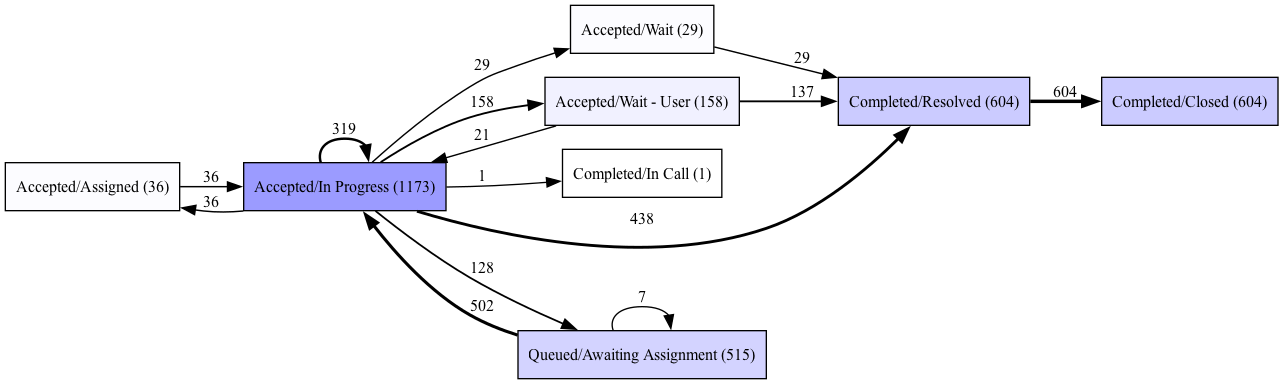

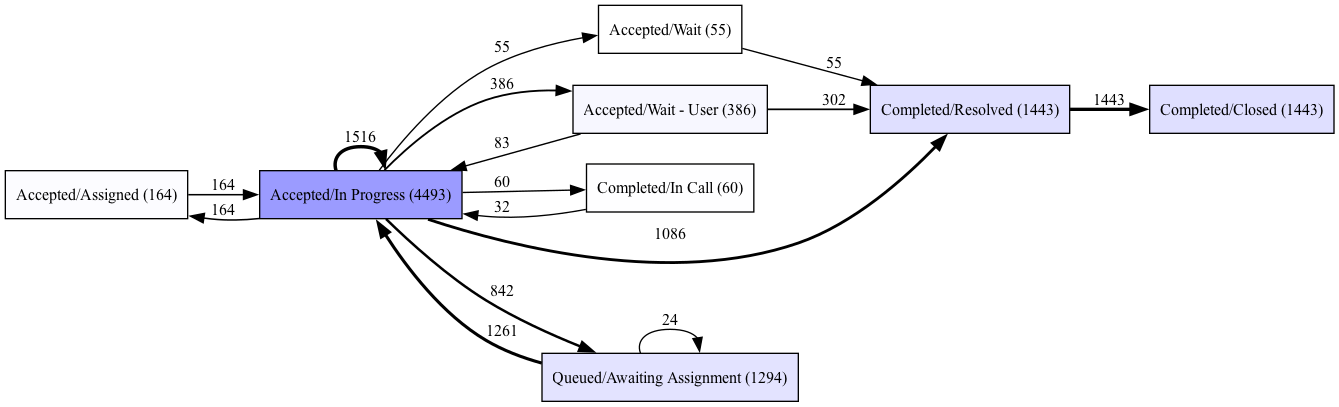

In [ ]:
from pm4py.visualization.dfg import visualizer as dfg_visualizer

gviz_dfg_a2 = dfg_visualizer.apply(dfg_a2, log=log_a2)
gviz_dfg_c = dfg_visualizer.apply(dfg_c, log=log_c)

dfg_visualizer.view(gviz_dfg_a2)
dfg_visualizer.view(gviz_dfg_c)


In [ ]:
# Convert DFGs to sets for comparison
dfg_a2_set = set(dfg_a2.items())
dfg_c_set = set(dfg_c.items())

common_edges = dfg_a2_set.intersection(dfg_c_set)
a2_unique = dfg_a2_set - dfg_c_set
c_unique = dfg_c_set - dfg_a2_set

print("Common activities/transitions:", common_edges)
print("Unique to Org A2:", a2_unique)
print("Unique to Org C:", c_unique)


Common activities/transitions: set()
Unique to Org A2: {(('Accepted/Wait - User', 'Accepted/In Progress'), 21), (('Accepted/In Progress', 'Queued/Awaiting Assignment'), 128), (('Accepted/Wait - User', 'Completed/Resolved'), 137), (('Accepted/In Progress', 'Accepted/Wait'), 29), (('Accepted/In Progress', 'Accepted/Assigned'), 36), (('Completed/Resolved', 'Completed/Closed'), 604), (('Accepted/Assigned', 'Accepted/In Progress'), 36), (('Accepted/In Progress', 'Accepted/Wait - User'), 158), (('Accepted/Wait', 'Completed/Resolved'), 29), (('Queued/Awaiting Assignment', 'Queued/Awaiting Assignment'), 7), (('Accepted/In Progress', 'Completed/In Call'), 1), (('Accepted/In Progress', 'Completed/Resolved'), 438), (('Accepted/In Progress', 'Accepted/In Progress'), 319), (('Queued/Awaiting Assignment', 'Accepted/In Progress'), 502)}
Unique to Org C: {(('Accepted/In Progress', 'Accepted/Wait'), 55), (('Completed/In Call', 'Accepted/In Progress'), 32), (('Completed/Resolved', 'Completed/Closed'), 1

In [ ]:
# Fix import for case_statistics in pm4py >=2.2.0
from pm4py.statistics.traces.generic.log import case_statistics

variants_a2 = case_statistics.get_variant_statistics(log_a2)
variants_c = case_statistics.get_variant_statistics(log_c)

print("Variants A2:", [v['variant'] for v in variants_a2[:5]])
print("Variants C:", [v['variant'] for v in variants_c[:5]])

Variants A2: [('Queued/Awaiting Assignment', 'Accepted/In Progress', 'Completed/Resolved', 'Completed/Closed'), ('Accepted/In Progress', 'Accepted/In Progress', 'Completed/Resolved', 'Completed/Closed'), ('Queued/Awaiting Assignment', 'Accepted/In Progress', 'Accepted/Wait - User', 'Completed/Resolved', 'Completed/Closed'), ('Accepted/In Progress', 'Accepted/In Progress', 'Accepted/Wait - User', 'Completed/Resolved', 'Completed/Closed'), ('Accepted/In Progress', 'Accepted/In Progress', 'Queued/Awaiting Assignment', 'Accepted/In Progress', 'Completed/Resolved', 'Completed/Closed')]
Variants C: [('Accepted/In Progress', 'Accepted/In Progress', 'Completed/Resolved', 'Completed/Closed'), ('Queued/Awaiting Assignment', 'Accepted/In Progress', 'Completed/Resolved', 'Completed/Closed'), ('Accepted/In Progress', 'Accepted/In Progress', 'Queued/Awaiting Assignment', 'Accepted/In Progress', 'Completed/Resolved', 'Completed/Closed'), ('Accepted/In Progress', 'Accepted/In Progress'), ('Accepted/In

In [ ]:
from pm4py.algo.discovery.alpha import algorithm as  Inductive_Miner
# Merge logs to discover a common model
from pm4py.objects.log.obj import EventLog

combined_log = EventLog(list(log_a2) + list(log_c))

# Discover Petri net from combined log using Alpha Miner
net, initial_marking, final_marking = Inductive_Miner.apply(combined_log)

# Store logs in a dictionary
dept_logs = {
    "Org line A2": log_a2,
    "Org line C": log_c
}

# Token Replay Conformance
conformance_results = {}

for dept, org_log in dept_logs.items():
    replay_results = token_replay.apply(org_log, net, initial_marking, final_marking)
    fit_traces = sum(1 for trace in replay_results if trace['trace_is_fit'])
    total_traces = len(org_log)
    conformance_ratio = fit_traces / total_traces if total_traces > 0 else 0

    conformance_results[dept] = {
        'total_traces': total_traces,
        'fit_traces': fit_traces,
        'conformance_ratio': conformance_ratio
    }

    print(f"\nConformance for department {dept}:")
    print(f"Total traces: {total_traces}")
    print(f"Fit traces: {fit_traces}")
    print(f"Conformance ratio: {conformance_ratio:.2%}")

replaying log with TBR, completed traces :: 100%|██████████| 40/40 [00:00<00:00, 5824.21it/s]



Conformance for department Org line A2:
Total traces: 675
Fit traces: 7
Conformance ratio: 1.04%


replaying log with TBR, completed traces :: 100%|██████████| 52/52 [00:00<00:00, 5766.89it/s]


Conformance for department Org line C:
Total traces: 1865
Fit traces: 5
Conformance ratio: 0.27%


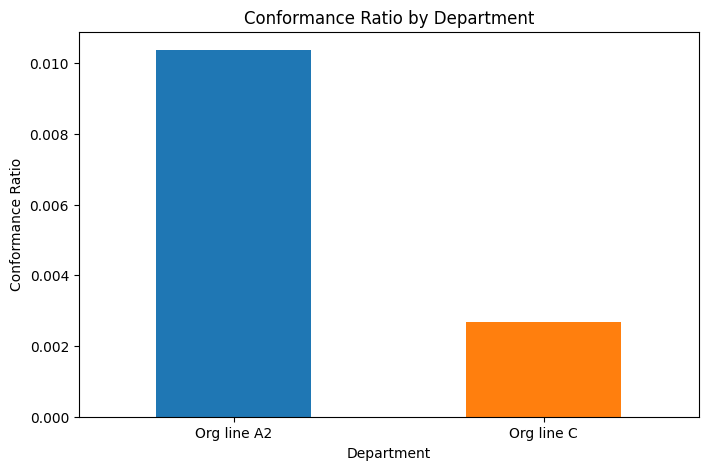

In [ ]:

# Visualize conformance ratios
conformance_df = pd.DataFrame.from_dict(conformance_results, orient='index')
plt.figure(figsize=(8, 5))
conformance_df['conformance_ratio'].plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Conformance Ratio by Department')
plt.xlabel('Department')
plt.ylabel('Conformance Ratio')
plt.xticks(rotation=0)
plt.show()